# Gradient Boosting Regressor

### Authors:
 - Benjamín Vega
 - Iuliana Illie

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator

import matplotlib.pyplot as plt

In [5]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

### Load data in libsvm format

We use libsvm format because spark get better results. The format is: Label, features vector named from 1 to n being n the number of features.

In [6]:
# Load and parse the data file, converting it to a DataFrame.
data = spark_session.read.options(numFeatures=10).format("libsvm").load("data/data_file.txt")

In [7]:
data.show()

+----------+--------------------+
|     label|            features|
+----------+--------------------+
|115.970001|(10,[0,1,2,3,4,5,...|
|    116.32|(10,[0,1,2,3,4,5,...|
|118.690002|(10,[0,1,2,3,4,5,...|
|119.029999|(10,[0,1,2,3,4,5,...|
|114.949997|(10,[0,1,2,3,4,5,...|
|110.440002|(10,[0,1,2,3,4,5,...|
|108.769997|(10,[0,1,2,3,4,5,...|
|108.860001|(10,[0,1,2,3,4,5,...|
|    115.32|(10,[0,1,2,3,4,5,...|
|111.199997|(10,[0,1,2,3,4,5,...|
|116.599998|(10,[0,1,2,3,4,5,...|
|115.050003|(10,[0,1,2,3,4,5,...|
|115.040001|(10,[0,1,2,3,4,5,...|
|    115.75|(10,[0,1,2,3,4,5,...|
|116.870003|(10,[0,1,2,3,4,5,...|
|117.510002|(10,[0,1,2,3,4,5,...|
|115.980003|(10,[0,1,2,3,4,5,...|
|119.019997|(10,[0,1,2,3,4,5,...|
|120.709999|(10,[0,1,2,3,4,5,...|
|121.190002|(10,[0,1,2,3,4,5,...|
+----------+--------------------+
only showing top 20 rows



### Split data into train and test sets and normalize 

We indicate 70% for training and 30% for test. `randomSplit` normalizes the data.

In [8]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

+--------+
|   label|
+--------+
|0.115513|
|0.116629|
|0.117188|
|0.117188|
|0.117188|
|0.117746|
|0.117746|
|0.118862|
| 0.12221|
| 0.12221|
+--------+
only showing top 10 rows

None


### Training

Creating a model. We have to indicate features and taget (label).

In [9]:
# Train model.
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label')

We prepared `ParamGridBuilder`, builder for a param grid used in grid search-based model selection and find the best configuration. we indicate `maxIter`, `maxDepth` and `maxBins`.

In [10]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [int(x) for x in [10]]) \
    .addGrid(gbt.maxDepth, [int(x) for x in [10]]) \
    .addGrid(gbt.maxBins, [int(x) for x in [32]]) \
    .build()
    #.addGrid(r

Cross Validation, we indicate model, paramGrid and evaluator. To evaluate we need a evaluator with metrics, since we are faced with a regression problem, we use root-mean-square error (rmse) as a metric.

In [11]:
#evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

#crossvalidation
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

We train using corss validaton fit.

In [12]:
cvModel = crossval.fit(trainingData)

### Evaluation

We have to get predictions from test data.

In [13]:
predictions = cvModel.transform(testData)

In [14]:
predictions.select("prediction", "label", "features").show(10)

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
|0.17038388578968114|0.118304|(10,[0,1,2,3,4,5,...|
| 0.1505586182736725|0.118862|(10,[0,1,2,3,4,5,...|
| 0.1505586182736725| 0.12221|(10,[0,1,2,3,4,5,...|
| 0.1503082476941044|0.122768|(10,[0,1,2,3,4,5,...|
| 0.1505586182736725|0.124442|(10,[0,1,2,3,4,5,...|
| 0.1505586182736725|0.127232|(10,[0,1,2,3,4,5,...|
| 0.1718649466989883|0.135603|(10,[0,1,2,3,4,5,...|
|0.14922687882114785|0.136161|(10,[0,1,2,3,4,5,...|
| 0.1503082476941044|0.137277|(10,[0,1,2,3,4,5,...|
| 0.1508791480671117|0.137277|(10,[0,1,2,3,4,5,...|
+-------------------+--------+--------------------+
only showing top 10 rows



We evaluate the predictions and show the results. We shoe real price to predicition price. A diagonal would be the perfect target.

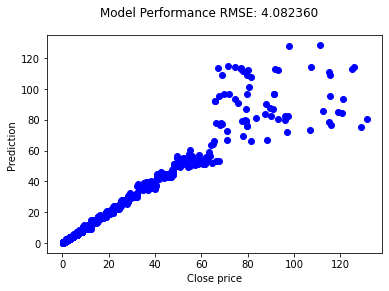

RMSE: 4.082359867310072


In [15]:
rmse = evaluator.evaluate(predictions)


rfResult = predictions.toPandas()
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print("RMSE:", rmse)

#### Best model

In [16]:
bestModel = cvModel.bestModel

Max. depth

In [17]:
bestModel.getMaxDepth()

10

Max. Iter.

In [18]:
bestModel.getMaxIter()

10

Max. Bins

In [19]:
bestModel.getMaxBins()

32

### Feature Importance for gradient boosting regressor

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Text(0.5, 1.0, 'Feature Importances')

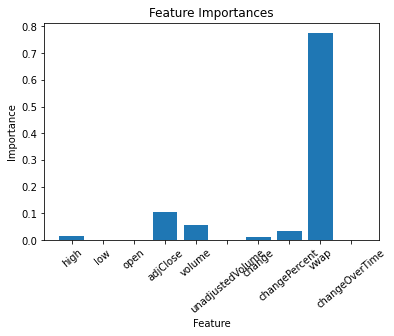

In [21]:
# Extract the important feature values
importances = bestModel.featureImportances

x_values = list(range(len(importances)))
print(x_values)
feature_list = ['high','low','open','adjClose','volume','unadjustedVolume','change','changePercent','vwap','changeOverTime']

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')